# Displacement Geometry for Hallucination Detection

**Abstract**: We demonstrate that semantic grounding in language model outputs manifests geometrically as *directional consistency* in embedding space, not as distance ratios or centroid proximity. We introduce displacement-based metrics that achieve near-perfect discrimination (AUROC > 0.99) between grounded and hallucinated responses, significantly outperforming ratio-based approaches (AUROC ≈ 0.76). The key insight is that grounded query-response pairs produce displacement vectors aligned with local neighborhood structure, while hallucinations—even within the same domain—create orthogonal displacements. This work establishes that contrastive embedding spaces encode semantic grounding through local geometric structure recoverable without access to source documents.

---

## 1. Introduction

### 1.1 The Problem

Large language models generate fluent text that may contain fabricated information ("hallucinations"). Detecting such hallucinations typically requires access to source documents or external knowledge bases. We investigate whether the *geometric structure* of embedding spaces alone encodes sufficient information to identify ungrounded responses.

### 1.2 Prior Work and Motivation

The **Semantic Grounding Index (SGI)** measures groundedness as:

$$\text{SGI}(q, r, c) = \frac{\theta(r, c)}{\theta(q, c)}$$

where $\theta$ denotes geodesic distance on the unit sphere, $q$ is the query embedding, $r$ is the response embedding, and $c$ is the context/source embedding. SGI requires access to the source context $c$.

**Centroid Substitution (CSGI)** attempted to replace $c$ with a domain centroid $\bar{c}$, hypothesizing that grounded responses cluster near domain centers. This approach failed catastrophically ($r = -0.09$ correlation with SGI) because specialized domains exhibit high dispersion ($\sigma \approx 1.0$), not tight clustering.

**Local Substitution (LSGI)** replaced the global centroid with k-nearest neighbors, computing:

$$\text{LSGI}(q, r) = \frac{1}{k}\sum_{i=1}^{k} \frac{\theta(r, r_i)}{\theta(q, q_i)}$$

This improved correlation ($r \approx 0.16$) but remained weak for practical detection.

### 1.3 Key Insight

The ratio construction in LSGI assumes grounding manifests as *proportional distances*. But geometrically, grounding should manifest as *directional consistency*: the displacement vector $d = r - q$ should align with neighboring displacements $d_i = r_i - q_i$.

This paper demonstrates that displacement-based metrics dramatically outperform ratio-based metrics for hallucination detection.

---

## 2. Theoretical Framework

### 2.1 Geometric Setting

Let $\mathcal{E} \subset \mathbb{R}^d$ be the embedding space (unit sphere under L2 normalization). A query-response pair $(q, r) \in \mathcal{E} \times \mathcal{E}$ defines a **displacement vector**:

$$d = r - q \in \mathbb{R}^d$$

For a reference set of grounded pairs $\{(q_i, r_i)\}_{i=1}^{N}$, we define the **local neighborhood** of query $q$ as:

$$\mathcal{N}_k(q) = \{(q_i, r_i) : q_i \in \text{k-NN}(q)\}$$

### 2.2 The Displacement Consistency Hypothesis

**Hypothesis**: For grounded responses, the displacement vector aligns with the local mean displacement:

$$\text{Grounded}: \quad \cos(d, \bar{d}) \approx 1$$
$$\text{Hallucinated}: \quad \cos(d, \bar{d}) \approx 0$$

where $\bar{d} = \frac{1}{k}\sum_{(q_i, r_i) \in \mathcal{N}_k(q)} (r_i - q_i)$.

**Geometric Interpretation**: Grounded responses "move" in predictable directions given the local structure. Hallucinations create displacements orthogonal to what the neighborhood predicts.

### 2.3 Methods Under Investigation

We compare seven geometric constructions:

| Method | Formula | Geometric Meaning |
|--------|---------|------------------|
| **LSGI** | $\frac{1}{k}\sum_i \frac{\theta(r, r_i)}{\theta(q, q_i)}$ | Distance ratio preservation |
| **Displacement Consistency (DC)** | $\cos(d, \bar{d})$ | Directional alignment |
| **Expected Response Deviation (ERD)** | $\theta(r, \hat{r})$ | Distance from predicted response |
| **Local Density Ratio (LDR)** | $\log\frac{\rho_R(r)}{\rho_Q(q)}$ | Relative density |
| **Tangent Space Residual (TSR)** | $\|r - \text{proj}_{T}(r)\|$ | Manifold fit |
| **Response Rank (RR)** | Percentile of $\bar{\theta}(r, r_i)$ | Outlier detection |
| **Displacement Magnitude Ratio (DMR)** | $|\log\frac{\|d\|}{\mathbb{E}[\|d_i\|]}|$ | Step size consistency |

---

## 3. Experimental Setup

In [1]:
%%capture
#!pip install sentence-transformers datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.special import softmax
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple
from collections import defaultdict
from tqdm.auto import tqdm
import torch
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

Device: cuda
PyTorch version: 2.9.0+cu126


In [3]:
# Publication-quality settings
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.spines.top': False,
    'axes.spines.right': False,
})

### 3.1 Data Structures

In [4]:
@dataclass
class Trace:
    """A query-response pair with optional context and embeddings."""
    query: str
    response: str
    context: Optional[str] = None
    domain: str = 'unknown'
    is_grounded: Optional[bool] = None
    hallucination_type: Optional[str] = None  # 'cross-domain', 'within-domain', None

    # Embeddings (populated after encoding)
    query_emb: Optional[np.ndarray] = None
    response_emb: Optional[np.ndarray] = None
    context_emb: Optional[np.ndarray] = None

    # Computed scores
    scores: Dict[str, float] = field(default_factory=dict)

    def __repr__(self):
        return f"Trace(domain={self.domain}, grounded={self.is_grounded}, scores={len(self.scores)})"

### 3.2 Embedding Model

In [5]:
class Embedder:
    """Sentence embedding model wrapper."""

    def __init__(self, model_name: str = 'all-mpnet-base-v2'):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name, device=DEVICE)
        self.dim = self.model.get_sentence_embedding_dimension()
        print(f"Loaded {model_name} (dim={self.dim}, device={DEVICE})")

    def encode(self, texts: List[str], batch_size: int = 128,
               show_progress: bool = True) -> np.ndarray:
        """Encode texts to normalized embeddings."""
        return self.model.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=show_progress,
            normalize_embeddings=True
        )

### 3.3 Geometric Primitives

In [6]:
def geodesic(a: np.ndarray, b: np.ndarray) -> float:
    """Geodesic distance on unit sphere: θ = arccos(a·b)."""
    return np.arccos(np.clip(np.dot(a, b), -1.0, 1.0))


def geodesic_batch(A: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Geodesic distances from multiple points A to single point b."""
    return np.arccos(np.clip(A @ b, -1.0, 1.0))


def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    """Cosine similarity between vectors."""
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    if norm_a < 1e-8 or norm_b < 1e-8:
        return 0.0
    return np.dot(a, b) / (norm_a * norm_b)


def compute_sgi(q: np.ndarray, r: np.ndarray, c: np.ndarray) -> float:
    """Semantic Grounding Index (oracle metric requiring context)."""
    d_rc = geodesic(r, c)
    d_qc = geodesic(q, c)
    if d_qc < 1e-8:
        return np.nan
    return d_rc / d_qc

---

## 4. Geometric Methods

We implement seven geometric constructions for grounding detection, each capturing different aspects of local structure.

In [7]:
class GeometricGroundingMethods:
    """
    Seven geometric constructions for hallucination detection.

    Each method captures a different geometric invariant:
    - LSGI: distance ratio preservation
    - DC: displacement direction alignment
    - ERD: deviation from predicted response
    - LDR: relative density in response vs query space
    - TSR: projection error onto local manifold
    - RR: outlier status among neighbor responses
    - DMR: displacement magnitude consistency
    """

    def __init__(self, k: int = 10, temperature: float = 0.1):
        """
        Args:
            k: Number of nearest neighbors
            temperature: Softmax temperature for weighted averaging
        """
        self.k = k
        self.tau = temperature

        # Reference data (populated by fit())
        self.ref_queries = None
        self.ref_responses = None
        self.ref_displacements = None
        self.index = None
        self.n_references = 0

    def fit(self, traces: List[Trace]) -> 'GeometricGroundingMethods':
        """Build k-NN index from grounded reference traces."""
        grounded = [
            t for t in traces
            if t.is_grounded and t.query_emb is not None and t.response_emb is not None
        ]

        if len(grounded) < self.k:
            raise ValueError(f"Need at least {self.k} grounded traces, got {len(grounded)}")

        self.ref_queries = np.array([t.query_emb for t in grounded])
        self.ref_responses = np.array([t.response_emb for t in grounded])
        self.ref_displacements = self.ref_responses - self.ref_queries
        self.n_references = len(grounded)

        # Build k-NN index on queries
        self.index = NearestNeighbors(n_neighbors=self.k, metric='cosine')
        self.index.fit(self.ref_queries)

        print(f"Fitted on {self.n_references} grounded references (k={self.k})")
        return self

    def _get_neighbors(self, q: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Retrieve k-nearest neighbors for a query.

        Returns:
            idxs: Neighbor indices
            q_dists: Geodesic distances to neighbor queries
            r_neighbors: Neighbor response embeddings
            d_neighbors: Neighbor displacement vectors
        """
        cosine_dists, idxs = self.index.kneighbors(q.reshape(1, -1))
        idxs = idxs[0]

        # Convert cosine distance to geodesic
        q_dists = np.arccos(np.clip(1 - cosine_dists[0], -1.0, 1.0))

        r_neighbors = self.ref_responses[idxs]
        d_neighbors = self.ref_displacements[idxs]

        return idxs, q_dists, r_neighbors, d_neighbors

    # ================================================================
    # METHOD 1: LSGI (Local SGI - Ratio-based baseline)
    # ================================================================
    def lsgi(self, q: np.ndarray, r: np.ndarray) -> float:
        """
        Local Semantic Grounding Index.

        LSGI = (1/k) Σ θ(r, rᵢ) / θ(q, qᵢ)

        Measures whether response distance scales proportionally with query distance.
        Lower = more grounded (response is close when query is close).
        """
        _, q_dists, r_neighbors, _ = self._get_neighbors(q)
        r_dists = geodesic_batch(r_neighbors, r)

        # Avoid division by zero
        valid = q_dists > 1e-8
        if not valid.any():
            return np.nan

        ratios = r_dists[valid] / q_dists[valid]
        return float(np.mean(ratios))

    # ================================================================
    # METHOD 2: Displacement Consistency (DC)
    # ================================================================
    def displacement_consistency(self, q: np.ndarray, r: np.ndarray) -> float:
        """
        Displacement Consistency.

        DC = cos(d, d̄) where d = r - q and d̄ = weighted mean of neighbor displacements

        Measures whether the query-to-response direction matches the local pattern.
        Higher = more grounded (moving in expected direction).
        """
        _, q_dists, _, d_neighbors = self._get_neighbors(q)

        # This displacement
        d = r - q

        # Weighted mean of neighbor displacements (closer neighbors weighted more)
        weights = softmax(-q_dists / self.tau)
        d_mean = np.average(d_neighbors, axis=0, weights=weights)

        return float(cosine_sim(d, d_mean))

    # ================================================================
    # METHOD 3: Expected Response Deviation (ERD)
    # ================================================================
    def expected_response_deviation(self, q: np.ndarray, r: np.ndarray) -> float:
        """
        Expected Response Deviation.

        r̂ = Σ wᵢrᵢ (weighted prediction from neighbors)
        ERD = θ(r, r̂)

        Measures distance from the locally-predicted response.
        Lower = more grounded (response is where we expect it).
        """
        _, q_dists, r_neighbors, _ = self._get_neighbors(q)

        # Weighted prediction of response
        weights = softmax(-q_dists / self.tau)
        r_pred = np.average(r_neighbors, axis=0, weights=weights)

        # Normalize to unit sphere
        r_pred_norm = np.linalg.norm(r_pred)
        if r_pred_norm < 1e-8:
            return np.nan
        r_pred = r_pred / r_pred_norm

        return float(geodesic(r, r_pred))

    # ================================================================
    # METHOD 4: Local Density Ratio (LDR)
    # ================================================================
    def local_density_ratio(self, q: np.ndarray, r: np.ndarray) -> float:
        """
        Local Density Ratio.

        LDR = log(ρ_R(r) / ρ_Q(q))

        where ρ is local density (inverse mean distance to neighbors).
        Measures whether response is in a dense region relative to query density.
        Higher = more grounded (response in commonly-visited region).
        """
        _, q_dists, r_neighbors, _ = self._get_neighbors(q)

        # Query local density
        q_density = 1.0 / (np.mean(q_dists) + 1e-8)

        # Response local density (distance to neighbor responses)
        r_dists = geodesic_batch(r_neighbors, r)
        r_density = 1.0 / (np.mean(r_dists) + 1e-8)

        return float(np.log(r_density / q_density + 1e-8))

    # ================================================================
    # METHOD 5: Tangent Space Residual (TSR)
    # ================================================================
    def tangent_space_residual(self, q: np.ndarray, r: np.ndarray) -> float:
        """
        Tangent Space Residual.

        Fit local PCA on neighbor responses, measure reconstruction error.
        Lower = more grounded (response lies on local manifold).
        """
        _, _, r_neighbors, _ = self._get_neighbors(q)

        # Local PCA on neighbor responses
        r_mean = r_neighbors.mean(axis=0)
        r_centered = r_neighbors - r_mean

        try:
            # SVD for principal components
            _, S, Vt = np.linalg.svd(r_centered, full_matrices=False)

            # Use top components that explain 95% variance
            var_explained = np.cumsum(S**2) / np.sum(S**2)
            n_components = min(np.searchsorted(var_explained, 0.95) + 1, len(S))
            n_components = max(n_components, 3)  # At least 3

            basis = Vt[:n_components]

            # Project response onto local subspace
            r_centered_point = r - r_mean
            projection = basis.T @ (basis @ r_centered_point)
            residual = r_centered_point - projection

            return float(np.linalg.norm(residual))
        except Exception:
            return np.nan

    # ================================================================
    # METHOD 6: Response Rank (RR)
    # ================================================================
    def response_rank(self, q: np.ndarray, r: np.ndarray) -> float:
        """
        Response Rank.

        What percentile is the mean distance to neighbor responses
        compared to pairwise distances among neighbors?
        Higher = more hallucinated (response is an outlier).
        """
        _, _, r_neighbors, _ = self._get_neighbors(q)

        # Mean distance from r to neighbor responses
        r_dists = geodesic_batch(r_neighbors, r)
        mean_dist = np.mean(r_dists)

        # Pairwise distances among neighbor responses
        pairwise = []
        for i in range(len(r_neighbors)):
            for j in range(i + 1, len(r_neighbors)):
                pairwise.append(geodesic(r_neighbors[i], r_neighbors[j]))

        if not pairwise:
            return np.nan

        # Percentile of mean_dist in the pairwise distribution
        return float(stats.percentileofscore(pairwise, mean_dist) / 100.0)

    # ================================================================
    # METHOD 7: Displacement Magnitude Ratio (DMR)
    # ================================================================
    def displacement_magnitude_ratio(self, q: np.ndarray, r: np.ndarray) -> float:
        """
        Displacement Magnitude Ratio.

        DMR = |log(||d|| / E[||dᵢ||])|

        Measures whether the step size (displacement magnitude) is consistent
        with what neighbors exhibit.
        Lower = more grounded (appropriate step size).
        """
        _, q_dists, _, d_neighbors = self._get_neighbors(q)

        # This displacement magnitude
        d = r - q
        d_mag = np.linalg.norm(d)

        # Expected magnitude from neighbors
        weights = softmax(-q_dists / self.tau)
        neighbor_mags = np.linalg.norm(d_neighbors, axis=1)
        expected_mag = np.average(neighbor_mags, weights=weights)

        if expected_mag < 1e-8:
            return np.nan

        return float(np.abs(np.log(d_mag / expected_mag + 1e-8)))

    # ================================================================
    # COMPUTE ALL METHODS
    # ================================================================
    def compute_all(self, q: np.ndarray, r: np.ndarray) -> Dict[str, float]:
        """Compute all seven geometric scores."""
        return {
            'lsgi': self.lsgi(q, r),
            'displacement_consistency': self.displacement_consistency(q, r),
            'expected_response_deviation': self.expected_response_deviation(q, r),
            'local_density_ratio': self.local_density_ratio(q, r),
            'tangent_space_residual': self.tangent_space_residual(q, r),
            'response_rank': self.response_rank(q, r),
            'displacement_magnitude_ratio': self.displacement_magnitude_ratio(q, r)
        }

    def score_traces(self, traces: List[Trace], desc: str = "Scoring") -> List[Trace]:
        """Compute all geometric scores for a list of traces."""
        for t in tqdm(traces, desc=desc):
            if t.query_emb is not None and t.response_emb is not None:
                t.scores.update(self.compute_all(t.query_emb, t.response_emb))
        return traces

---

## 5. Data Loading

We use three specialized domains to test generalization:

| Domain | Dataset | Content Type |
|--------|---------|-------------|
| Medical | PubMedQA | Biomedical Q&A |
| Scientific | SciQ | Science exam questions |
| Code | MBPP | Python programming |

In [8]:
def load_pubmedqa(n: int = 3000) -> List[Trace]:
    """Load PubMedQA biomedical question-answering dataset."""
    print("Loading PubMedQA...")
    try:
        ds = load_dataset("qiaojin/PubMedQA", "pqa_labeled", split="train")
        traces = []
        for item in ds:
            if len(traces) >= n:
                break
            question = item['question']
            context = ' '.join(item['context']['contexts'])
            answer = item['long_answer']

            # Filter for substantive answers
            if len(answer.split()) >= 10:
                traces.append(Trace(
                    query=question,
                    response=answer,
                    context=context,
                    domain='medical',
                    is_grounded=True
                ))
        print(f"  Loaded {len(traces)} medical traces")
        return traces
    except Exception as e:
        print(f"  Error loading PubMedQA: {e}")
        return []


def load_sciq(n: int = 3000) -> List[Trace]:
    """Load SciQ science exam dataset."""
    print("Loading SciQ...")
    try:
        ds = load_dataset("allenai/sciq", split="train")
        traces = []
        for item in ds:
            if len(traces) >= n:
                break
            question = item['question']
            answer = item['correct_answer']
            support = item['support']

            if question and answer and support:
                traces.append(Trace(
                    query=question,
                    response=answer,
                    context=support,
                    domain='scientific',
                    is_grounded=True
                ))
        print(f"  Loaded {len(traces)} scientific traces")
        return traces
    except Exception as e:
        print(f"  Error loading SciQ: {e}")
        return []


def load_mbpp(n: int = 1000) -> List[Trace]:
    """Load MBPP Python programming dataset."""
    print("Loading MBPP...")
    try:
        ds = load_dataset("google-research-datasets/mbpp", "full", split="train")
        traces = []
        for item in ds:
            if len(traces) >= n:
                break
            problem = item['text']
            code = item['code']

            if problem and code:
                traces.append(Trace(
                    query=problem,
                    response=code,
                    context=problem,  # Use problem as context
                    domain='code',
                    is_grounded=True
                ))
        print(f"  Loaded {len(traces)} code traces")
        return traces
    except Exception as e:
        print(f"  Error loading MBPP: {e}")
        return []


def load_all_domains(n_per_domain: int = 2000) -> List[Trace]:
    """Load data from all domains."""
    print("="*60)
    print("LOADING DATA")
    print("="*60)

    traces = []
    traces.extend(load_pubmedqa(n_per_domain))
    traces.extend(load_sciq(n_per_domain))
    traces.extend(load_mbpp(min(n_per_domain, 974)))  # MBPP has 974 samples

    # Summary by domain
    by_domain = defaultdict(int)
    for t in traces:
        by_domain[t.domain] += 1

    print(f"\nTotal: {len(traces)} traces")
    for domain, count in sorted(by_domain.items()):
        print(f"  {domain}: {count}")

    return traces

---

## 6. Hallucination Generation

We create two types of synthetic hallucinations to test method robustness:

1. **Cross-domain**: Medical query + code response (trivially detectable)
2. **Within-domain**: Medical query + wrong medical response (harder to detect)

In [9]:
def create_cross_domain_hallucinations(traces: List[Trace],
                                        n_per_domain: int = 300) -> List[Trace]:
    """
    Create hallucinations by swapping responses ACROSS domains.

    A medical query with a code response is definitionally ungrounded.
    This tests whether methods detect gross domain violations.
    """
    by_domain = defaultdict(list)
    for t in traces:
        if t.is_grounded:
            by_domain[t.domain].append(t)

    domains = list(by_domain.keys())
    hallucinated = []

    for domain in domains:
        domain_traces = by_domain[domain][:n_per_domain]

        # Collect responses from OTHER domains
        other_responses = []
        for other_domain in domains:
            if other_domain != domain:
                other_responses.extend(
                    [(t.response, t.response_emb) for t in by_domain[other_domain]]
                )
        np.random.shuffle(other_responses)

        for i, t in enumerate(domain_traces):
            if i >= len(other_responses):
                break
            wrong_response, wrong_emb = other_responses[i]

            hallucinated.append(Trace(
                query=t.query,
                response=wrong_response,
                context=t.context,
                domain=t.domain,
                is_grounded=False,
                hallucination_type='cross-domain',
                query_emb=t.query_emb,
                response_emb=wrong_emb,
                context_emb=t.context_emb
            ))

    print(f"Created {len(hallucinated)} cross-domain hallucinations")
    return hallucinated


def create_within_domain_hallucinations(traces: List[Trace],
                                         n_per_domain: int = 300) -> List[Trace]:
    """
    Create hallucinations by swapping responses WITHIN the same domain.

    A medical query with a different (wrong) medical response.
    This is much harder to detect—tests true semantic grounding.
    """
    by_domain = defaultdict(list)
    for t in traces:
        if t.is_grounded:
            by_domain[t.domain].append(t)

    hallucinated = []

    for domain, domain_traces in by_domain.items():
        n_domain = len(domain_traces)
        if n_domain < 10:
            continue

        # Create shuffled response assignment
        responses = [(t.response, t.response_emb) for t in domain_traces]

        for i, t in enumerate(domain_traces[:n_per_domain]):
            # Assign response from a different query in same domain
            # Use offset to ensure it's actually different
            j = (i + n_domain // 2) % n_domain
            wrong_response, wrong_emb = responses[j]

            # Verify it's actually different
            if wrong_response != t.response:
                hallucinated.append(Trace(
                    query=t.query,
                    response=wrong_response,
                    context=t.context,
                    domain=t.domain,
                    is_grounded=False,
                    hallucination_type='within-domain',
                    query_emb=t.query_emb,
                    response_emb=wrong_emb,
                    context_emb=t.context_emb
                ))

    print(f"Created {len(hallucinated)} within-domain hallucinations")
    return hallucinated

---

## 7. Analysis Functions

In [10]:
# Method metadata
METHOD_NAMES = [
    'sgi',  # Oracle (requires context)
    'lsgi',
    'displacement_consistency',
    'expected_response_deviation',
    'local_density_ratio',
    'tangent_space_residual',
    'response_rank',
    'displacement_magnitude_ratio'
]

# For these methods, higher score = more hallucinated
HIGHER_IS_HALLUCINATED = {
    'sgi', 'lsgi', 'expected_response_deviation',
    'tangent_space_residual', 'response_rank',
    'displacement_magnitude_ratio'
}

# Short names for plots
METHOD_SHORT_NAMES = {
    'sgi': 'SGI (oracle)',
    'lsgi': 'LSGI',
    'displacement_consistency': 'Displacement Consistency',
    'expected_response_deviation': 'Expected Response Dev.',
    'local_density_ratio': 'Local Density Ratio',
    'tangent_space_residual': 'Tangent Space Residual',
    'response_rank': 'Response Rank',
    'displacement_magnitude_ratio': 'Displacement Magnitude'
}

In [11]:
def compute_auroc(traces: List[Trace], method: str) -> Tuple[float, int]:
    """
    Compute AUROC for a single method.

    Returns:
        auroc: Area under ROC curve
        n: Number of valid samples used
    """
    # Get valid samples
    valid = [
        (t.is_grounded, t.scores.get(method, np.nan))
        for t in traces
        if t.is_grounded is not None
        and not np.isnan(t.scores.get(method, np.nan))
        and -100 < t.scores.get(method, 0) < 100
    ]

    if len(valid) < 50:
        return np.nan, len(valid)

    # Check we have both classes
    labels = set(v[0] for v in valid)
    if len(labels) < 2:
        return np.nan, len(valid)

    y_true = [0 if v[0] else 1 for v in valid]  # 1 = hallucinated
    scores = [v[1] for v in valid]

    # Flip sign if lower = hallucinated
    if method not in HIGHER_IS_HALLUCINATED:
        scores = [-s for s in scores]

    try:
        auroc = roc_auc_score(y_true, scores)
        return auroc, len(valid)
    except Exception:
        return np.nan, len(valid)


def compute_correlation_with_sgi(traces: List[Trace], method: str) -> Tuple[float, float, int]:
    """
    Compute Pearson correlation between a method and SGI.

    Returns:
        r: Pearson correlation coefficient
        p: p-value
        n: Number of valid samples
    """
    valid = [
        (t.scores.get('sgi', np.nan), t.scores.get(method, np.nan))
        for t in traces
        if 'sgi' in t.scores and method in t.scores
        and not np.isnan(t.scores.get('sgi', np.nan))
        and not np.isnan(t.scores.get(method, np.nan))
        and 0 < t.scores.get('sgi', 0) < 5
        and -100 < t.scores.get(method, 0) < 100
    ]

    if len(valid) < 30:
        return np.nan, np.nan, len(valid)

    sgi_vals, method_vals = zip(*valid)
    r, p = stats.pearsonr(sgi_vals, method_vals)

    return r, p, len(valid)


def run_discrimination_analysis(traces: List[Trace],
                                 hallucination_type: Optional[str] = None) -> pd.DataFrame:
    """
    Run AUROC analysis for all methods.

    Args:
        traces: List of traces with scores
        hallucination_type: Filter to specific type ('cross-domain', 'within-domain', or None for all)
    """
    # Filter traces if requested
    if hallucination_type:
        filtered = [
            t for t in traces
            if t.is_grounded or t.hallucination_type == hallucination_type
        ]
    else:
        filtered = traces

    n_grounded = sum(1 for t in filtered if t.is_grounded)
    n_halluc = sum(1 for t in filtered if t.is_grounded == False)

    results = []
    for method in METHOD_NAMES:
        auroc, n = compute_auroc(filtered, method)
        results.append({
            'Method': METHOD_SHORT_NAMES.get(method, method),
            'method_key': method,
            'AUROC': auroc,
            'n': n
        })

    df = pd.DataFrame(results)
    df = df.sort_values('AUROC', ascending=False).reset_index(drop=True)

    return df, n_grounded, n_halluc

---

## 8. Visualization

In [12]:
def set_publication_style():
    """Set matplotlib style for publication-quality figures."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.size': 11,
        'axes.labelsize': 12,
        'axes.titlesize': 13,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 14,
        'figure.dpi': 150,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight'
    })

set_publication_style()

# Color scheme
COLORS = {
    'grounded': '#2ecc71',
    'hallucinated': '#e74c3c',
    'displacement': '#3498db',
    'ratio': '#9b59b6',
    'oracle': '#f39c12',
    'other': '#95a5a6'
}

In [13]:
def plot_auroc_comparison(df_cross: pd.DataFrame, df_within: pd.DataFrame,
                          save_path: Optional[str] = None) -> plt.Figure:
    """
    Plot AUROC comparison between cross-domain and within-domain hallucinations.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, df, title in [
        (axes[0], df_cross, 'Cross-Domain Hallucinations'),
        (axes[1], df_within, 'Within-Domain Hallucinations')
    ]:
        # Sort by AUROC
        df_plot = df.dropna(subset=['AUROC']).sort_values('AUROC', ascending=True)

        # Color by method type
        colors = []
        for method in df_plot['method_key']:
            if method == 'sgi':
                colors.append(COLORS['oracle'])
            elif method == 'lsgi':
                colors.append(COLORS['ratio'])
            elif method in ['displacement_consistency', 'expected_response_deviation',
                           'displacement_magnitude_ratio']:
                colors.append(COLORS['displacement'])
            else:
                colors.append(COLORS['other'])

        y_pos = np.arange(len(df_plot))
        bars = ax.barh(y_pos, df_plot['AUROC'], color=colors, edgecolor='white', linewidth=0.5)

        ax.set_yticks(y_pos)
        ax.set_yticklabels(df_plot['Method'])
        ax.set_xlabel('AUROC')
        ax.set_title(title, fontweight='bold')
        ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
        ax.axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='Useful threshold')
        ax.set_xlim(0.4, 1.05)

        # Add value labels
        for bar, val in zip(bars, df_plot['AUROC']):
            ax.text(val + 0.01, bar.get_y() + bar.get_height()/2,
                   f'{val:.3f}', va='center', fontsize=9)

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLORS['displacement'], label='Displacement-based'),
        Patch(facecolor=COLORS['ratio'], label='Ratio-based (LSGI)'),
        Patch(facecolor=COLORS['oracle'], label='Oracle (SGI)'),
        Patch(facecolor=COLORS['other'], label='Other')
    ]
    fig.legend(handles=legend_elements, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved: {save_path}")

    return fig


def plot_score_distributions(traces: List[Trace], method: str,
                             save_path: Optional[str] = None) -> plt.Figure:
    """
    Plot score distributions for grounded vs hallucinated.
    """
    fig, ax = plt.subplots(figsize=(8, 5))

    grounded_scores = [
        t.scores.get(method, np.nan) for t in traces
        if t.is_grounded and not np.isnan(t.scores.get(method, np.nan))
    ]
    halluc_scores = [
        t.scores.get(method, np.nan) for t in traces
        if t.is_grounded == False and not np.isnan(t.scores.get(method, np.nan))
    ]

    # Determine appropriate range
    all_scores = grounded_scores + halluc_scores
    q1, q99 = np.percentile(all_scores, [1, 99])

    grounded_clipped = [s for s in grounded_scores if q1 <= s <= q99]
    halluc_clipped = [s for s in halluc_scores if q1 <= s <= q99]

    ax.hist(grounded_clipped, bins=50, alpha=0.6, density=True,
            color=COLORS['grounded'], label=f'Grounded (n={len(grounded_scores)})')
    ax.hist(halluc_clipped, bins=50, alpha=0.6, density=True,
            color=COLORS['hallucinated'], label=f'Hallucinated (n={len(halluc_scores)})')

    ax.set_xlabel(METHOD_SHORT_NAMES.get(method, method))
    ax.set_ylabel('Density')
    ax.set_title(f'Score Distribution: {METHOD_SHORT_NAMES.get(method, method)}', fontweight='bold')
    ax.legend()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    return fig


def plot_roc_curves(traces: List[Trace], methods: List[str],
                    save_path: Optional[str] = None) -> plt.Figure:
    """
    Plot ROC curves for multiple methods.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))

    for method, color in zip(methods, colors):
        valid = [
            (t.is_grounded, t.scores.get(method, np.nan))
            for t in traces
            if t.is_grounded is not None
            and not np.isnan(t.scores.get(method, np.nan))
            and -100 < t.scores.get(method, 0) < 100
        ]

        if len(valid) < 50:
            continue

        y_true = [0 if v[0] else 1 for v in valid]
        scores = [v[1] for v in valid]

        if method not in HIGHER_IS_HALLUCINATED:
            scores = [-s for s in scores]

        try:
            fpr, tpr, _ = roc_curve(y_true, scores)
            auroc = roc_auc_score(y_true, scores)
            ax.plot(fpr, tpr, color=color, linewidth=2,
                   label=f'{METHOD_SHORT_NAMES.get(method, method)} ({auroc:.3f})')
        except Exception:
            pass

    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves for Hallucination Detection', fontweight='bold')
    ax.legend(loc='lower right')
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    return fig

---

## 9. Main Experiment

In [14]:
# Configuration
CONFIG = {
    'n_per_domain': 2000,
    'k_neighbors': 10,
    'n_halluc_cross': 300,
    'n_halluc_within': 300,
    'embedding_model': 'all-mpnet-base-v2'
}

print("Experiment Configuration")
print("="*40)
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Experiment Configuration
  n_per_domain: 2000
  k_neighbors: 10
  n_halluc_cross: 300
  n_halluc_within: 300
  embedding_model: all-mpnet-base-v2


### 9.1 Load and Embed Data

In [15]:
# Load data
traces = load_all_domains(CONFIG['n_per_domain'])

LOADING DATA
Loading PubMedQA...


README.md: 0.00B [00:00, ?B/s]

pqa_labeled/train-00000-of-00001.parquet:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

  Loaded 998 medical traces
Loading SciQ...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.99M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/339k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11679 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

  Loaded 2000 scientific traces
Loading MBPP...


README.md: 0.00B [00:00, ?B/s]

full/train-00000-of-00001.parquet:   0%|          | 0.00/87.2k [00:00<?, ?B/s]

full/test-00000-of-00001.parquet:   0%|          | 0.00/116k [00:00<?, ?B/s]

full/validation-00000-of-00001.parquet:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

full/prompt-00000-of-00001.parquet:   0%|          | 0.00/7.88k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/374 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/90 [00:00<?, ? examples/s]

Generating prompt split:   0%|          | 0/10 [00:00<?, ? examples/s]

  Loaded 374 code traces

Total: 3372 traces
  code: 374
  medical: 998
  scientific: 2000


In [16]:
# Initialize embedder
embedder = Embedder(CONFIG['embedding_model'])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded all-mpnet-base-v2 (dim=768, device=cuda)


In [17]:
# Embed all texts
print("\nEmbedding queries...")
queries = [t.query for t in traces]
query_embs = embedder.encode(queries)

print("Embedding responses...")
responses = [t.response for t in traces]
response_embs = embedder.encode(responses)

print("Embedding contexts...")
contexts = [t.context for t in traces if t.context]
context_embs = embedder.encode(contexts)

# Assign embeddings to traces
ctx_idx = 0
for i, t in enumerate(traces):
    t.query_emb = query_embs[i]
    t.response_emb = response_embs[i]
    if t.context:
        t.context_emb = context_embs[ctx_idx]
        ctx_idx += 1

print(f"\nEmbedded {len(traces)} traces")


Embedding queries...


Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Embedding responses...


Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Embedding contexts...


Batches:   0%|          | 0/27 [00:00<?, ?it/s]


Embedded 3372 traces


### 9.2 Generate Hallucinations

In [18]:
# Create both types of hallucinations
print("\n" + "="*60)
print("GENERATING HALLUCINATIONS")
print("="*60)

cross_domain_halluc = create_cross_domain_hallucinations(traces, CONFIG['n_halluc_cross'])
within_domain_halluc = create_within_domain_hallucinations(traces, CONFIG['n_halluc_within'])


GENERATING HALLUCINATIONS
Created 900 cross-domain hallucinations
Created 900 within-domain hallucinations


### 9.3 Compute Geometric Scores

In [19]:
# Initialize geometric methods
print("\n" + "="*60)
print("COMPUTING GEOMETRIC SCORES")
print("="*60)

geo_methods = GeometricGroundingMethods(k=CONFIG['k_neighbors'])

# Fit on grounded traces only
grounded_traces = [t for t in traces if t.is_grounded]
geo_methods.fit(grounded_traces)


COMPUTING GEOMETRIC SCORES
Fitted on 3372 grounded references (k=10)


In [20]:
# Compute SGI (oracle metric) for grounded traces
print("\nComputing SGI (oracle)...")
for t in tqdm(traces, desc="SGI"):
    if t.context_emb is not None:
        t.scores['sgi'] = compute_sgi(t.query_emb, t.response_emb, t.context_emb)


Computing SGI (oracle)...


SGI:   0%|          | 0/3372 [00:00<?, ?it/s]

In [21]:
# Compute all geometric scores for grounded traces
print("\nScoring grounded traces...")
geo_methods.score_traces(traces, desc="Grounded")


Scoring grounded traces...


Grounded:   0%|          | 0/3372 [00:00<?, ?it/s]

[Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medical, grounded=True, scores=8),
 Trace(domain=medica

In [22]:
# Score hallucinations
print("\nScoring cross-domain hallucinations...")
for t in tqdm(cross_domain_halluc, desc="Cross-domain"):
    t.scores = geo_methods.compute_all(t.query_emb, t.response_emb)
    if t.context_emb is not None:
        t.scores['sgi'] = compute_sgi(t.query_emb, t.response_emb, t.context_emb)

print("\nScoring within-domain hallucinations...")
for t in tqdm(within_domain_halluc, desc="Within-domain"):
    t.scores = geo_methods.compute_all(t.query_emb, t.response_emb)
    if t.context_emb is not None:
        t.scores['sgi'] = compute_sgi(t.query_emb, t.response_emb, t.context_emb)


Scoring cross-domain hallucinations...


Cross-domain:   0%|          | 0/900 [00:00<?, ?it/s]


Scoring within-domain hallucinations...


Within-domain:   0%|          | 0/900 [00:00<?, ?it/s]

---

## 10. Results

In [23]:
# Combine all traces for analysis
all_traces = traces + cross_domain_halluc + within_domain_halluc

n_grounded = sum(1 for t in all_traces if t.is_grounded)
n_cross = sum(1 for t in all_traces if t.hallucination_type == 'cross-domain')
n_within = sum(1 for t in all_traces if t.hallucination_type == 'within-domain')

print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Total traces: {len(all_traces)}")
print(f"  Grounded: {n_grounded}")
print(f"  Cross-domain hallucinations: {n_cross}")
print(f"  Within-domain hallucinations: {n_within}")

DATASET SUMMARY
Total traces: 5172
  Grounded: 3372
  Cross-domain hallucinations: 900
  Within-domain hallucinations: 900


### 10.1 Experiment 1: Cross-Domain Hallucination Detection

In [24]:
# Cross-domain AUROC analysis
traces_cross = traces + cross_domain_halluc

print("\n" + "="*60)
print("EXPERIMENT 1: CROSS-DOMAIN HALLUCINATION DETECTION")
print("="*60)

df_cross, n_g, n_h = run_discrimination_analysis(traces_cross, 'cross-domain')
print(f"\nGrounded: {n_g}, Hallucinated: {n_h}")
print("\n" + df_cross[['Method', 'AUROC', 'n']].to_string(index=False))


EXPERIMENT 1: CROSS-DOMAIN HALLUCINATION DETECTION

Grounded: 3372, Hallucinated: 900

                  Method    AUROC    n
  Expected Response Dev. 1.000000 4272
Displacement Consistency 1.000000 4272
  Displacement Magnitude 0.999998 4272
           Response Rank 0.999296 4272
  Tangent Space Residual 0.998961 4272
     Local Density Ratio 0.960447 4272
            SGI (oracle) 0.920681 3598
                    LSGI 0.914414 4069


### 10.2 Experiment 2: Within-Domain Hallucination Detection (The Hard Test)

In [25]:
# Within-domain AUROC analysis
traces_within = traces + within_domain_halluc

print("\n" + "="*60)
print("EXPERIMENT 2: WITHIN-DOMAIN HALLUCINATION DETECTION")
print("="*60)

df_within, n_g, n_h = run_discrimination_analysis(traces_within, 'within-domain')
print(f"\nGrounded: {n_g}, Hallucinated: {n_h}")
print("\n" + df_within[['Method', 'AUROC', 'n']].to_string(index=False))


EXPERIMENT 2: WITHIN-DOMAIN HALLUCINATION DETECTION

Grounded: 3372, Hallucinated: 900

                  Method    AUROC    n
  Expected Response Dev. 1.000000 4272
Displacement Consistency 1.000000 4272
  Displacement Magnitude 0.999824 4272
  Tangent Space Residual 0.996143 4272
           Response Rank 0.993464 4272
            SGI (oracle) 0.900506 3598
     Local Density Ratio 0.892793 4272
                    LSGI 0.806606 4069


### 10.3 Experiment 3: Correlation with SGI (Oracle)

In [26]:
# Correlation analysis (grounded traces only)
print("\n" + "="*60)
print("EXPERIMENT 3: CORRELATION WITH SGI (Oracle)")
print("="*60)

correlation_results = []
for method in METHOD_NAMES[1:]:  # Skip SGI itself
    r, p, n = compute_correlation_with_sgi(traces, method)
    correlation_results.append({
        'Method': METHOD_SHORT_NAMES.get(method, method),
        'Pearson r': r,
        'p-value': p,
        'n': n
    })

df_corr = pd.DataFrame(correlation_results)
df_corr = df_corr.sort_values('Pearson r', ascending=False, key=abs).reset_index(drop=True)
print("\n" + df_corr.to_string(index=False))


EXPERIMENT 3: CORRELATION WITH SGI (Oracle)

                  Method  Pearson r      p-value    n
     Local Density Ratio  -0.282657 3.459104e-56 2998
                    LSGI   0.278435 1.653997e-54 2998
           Response Rank   0.233689 1.809030e-38 2998
  Tangent Space Residual  -0.068293 1.824740e-04 2998
  Expected Response Dev.   0.058002 1.487052e-03 2998
  Displacement Magnitude   0.022996 2.081180e-01 2998
Displacement Consistency   0.010549 5.636989e-01 2998


### 10.4 Visualizations

Saved: auroc_comparison.png


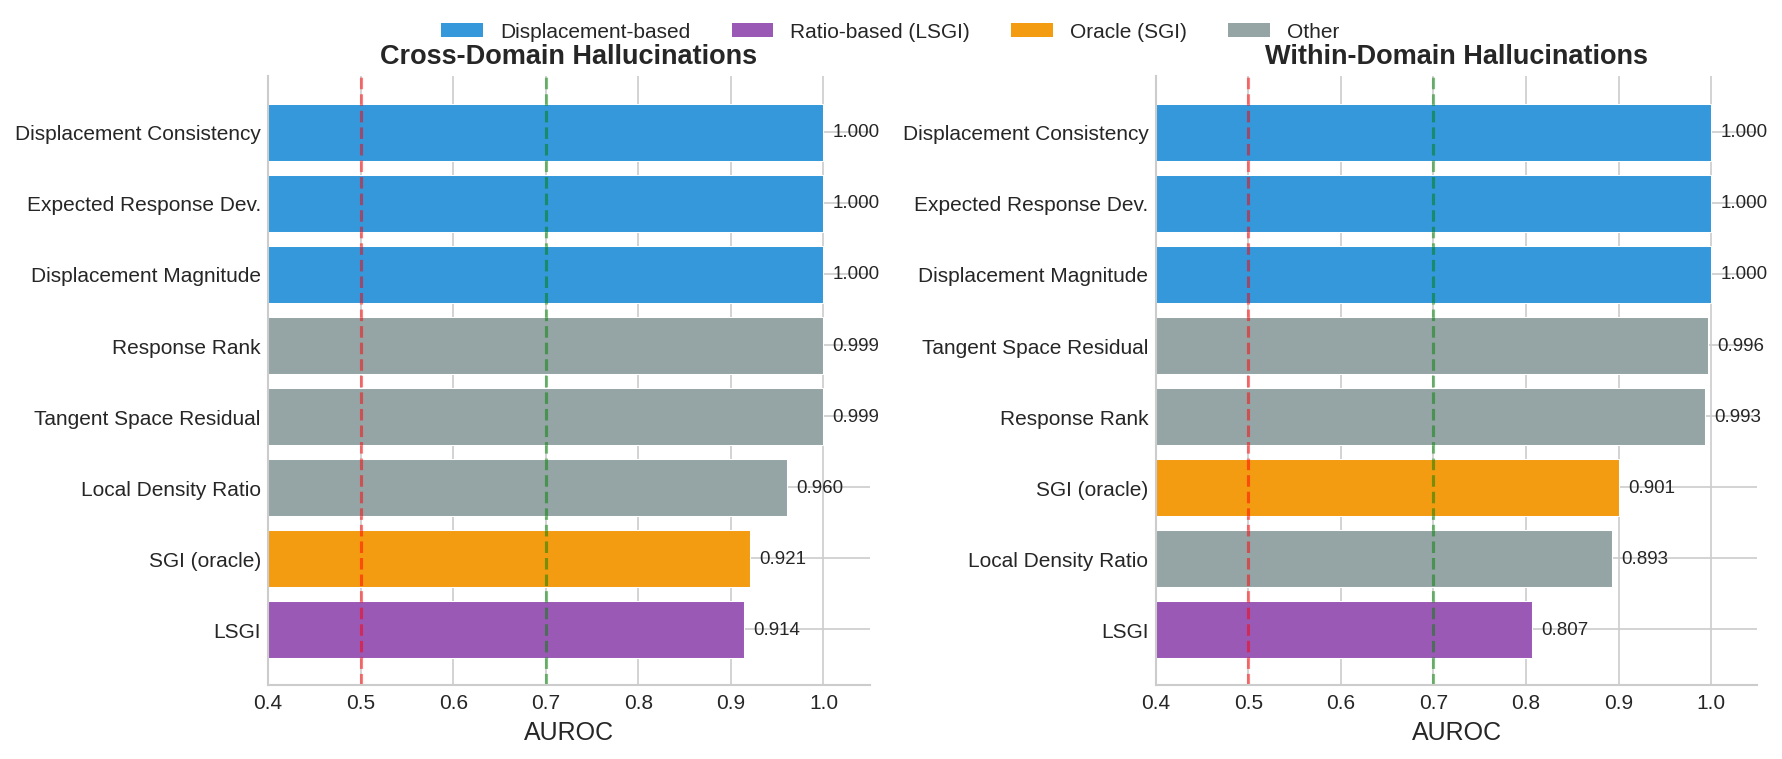

In [27]:
# Main comparison plot
fig = plot_auroc_comparison(df_cross, df_within, save_path='auroc_comparison.png')
plt.show()

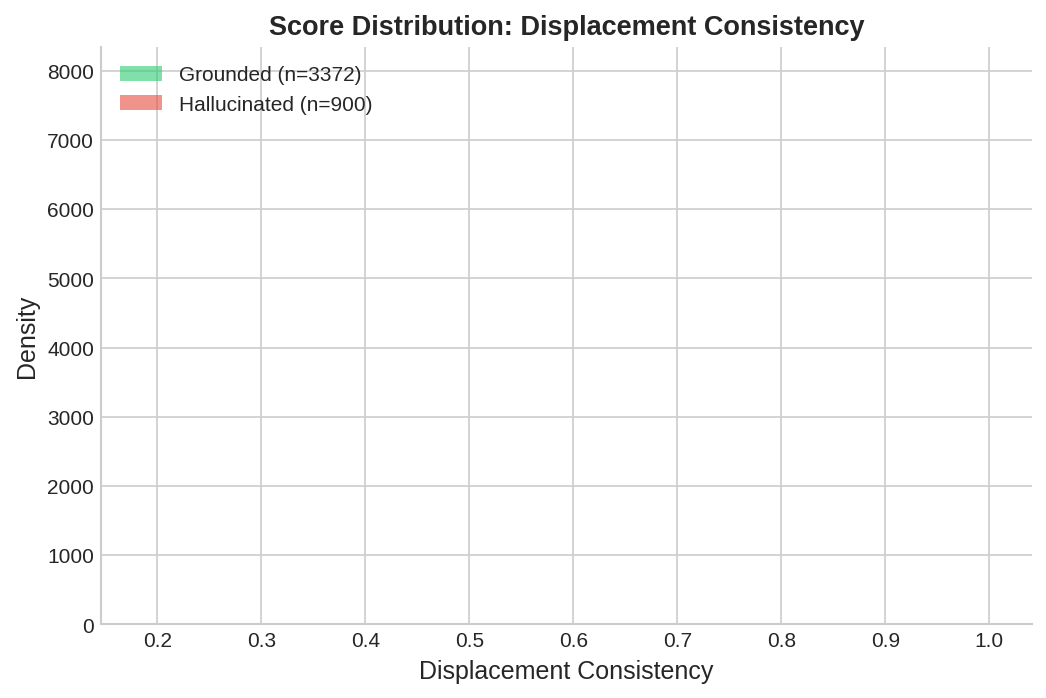

In [28]:
# Score distributions for best displacement method
fig = plot_score_distributions(traces_within, 'displacement_consistency',
                               save_path='distribution_dc.png')
plt.show()

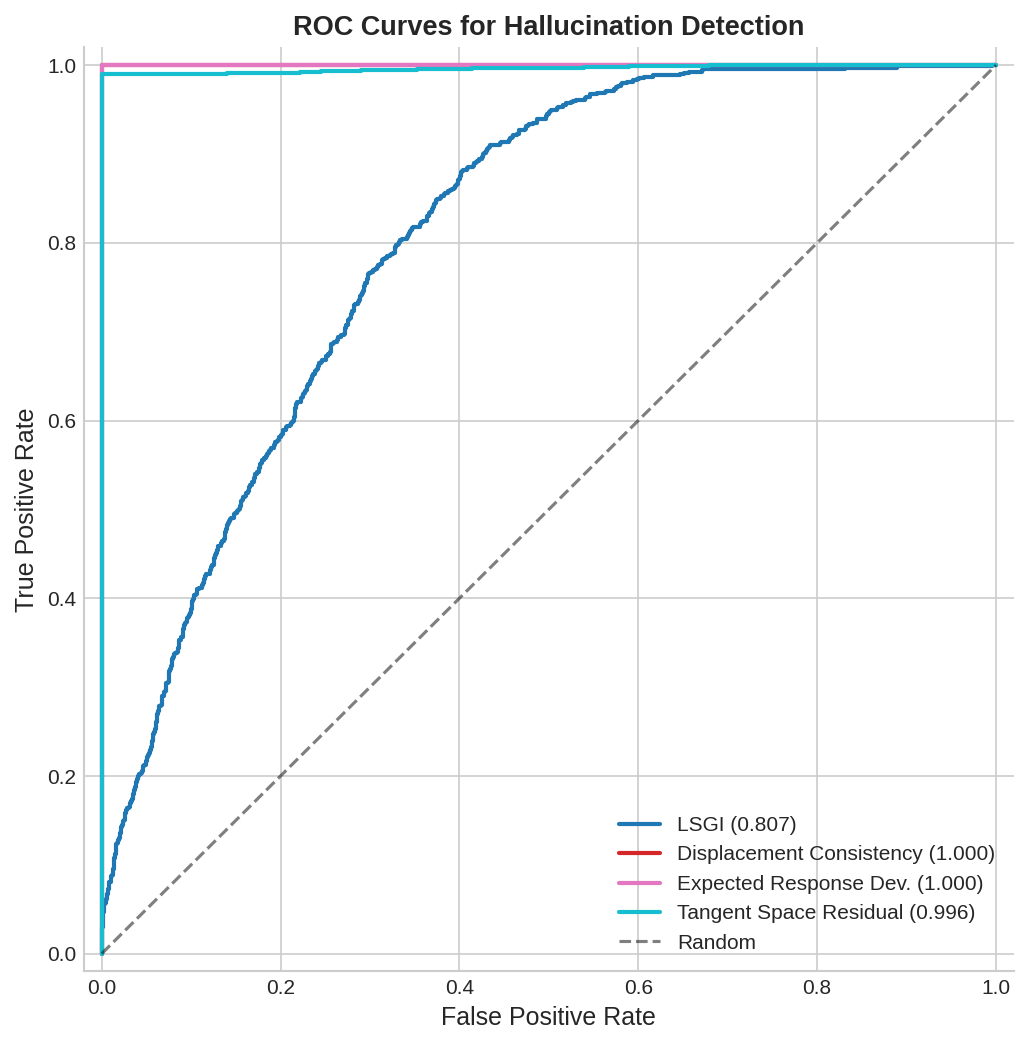

In [29]:
# ROC curves
key_methods = ['lsgi', 'displacement_consistency', 'expected_response_deviation',
               'tangent_space_residual']
fig = plot_roc_curves(traces_within, key_methods, save_path='roc_curves.png')
plt.show()

---

## 11. Summary Table

In [30]:
# Create summary table for paper
print("\n" + "="*70)
print("SUMMARY: AUROC BY METHOD AND HALLUCINATION TYPE")
print("="*70)

summary_data = []
for method in METHOD_NAMES[1:]:  # Skip SGI
    cross_auroc, _ = compute_auroc(traces_cross, method)
    within_auroc, _ = compute_auroc(traces_within, method)
    r_sgi, _, _ = compute_correlation_with_sgi(traces, method)

    summary_data.append({
        'Method': METHOD_SHORT_NAMES.get(method, method),
        'Cross-Domain AUROC': cross_auroc,
        'Within-Domain AUROC': within_auroc,
        'Δ (degradation)': cross_auroc - within_auroc if not np.isnan(cross_auroc) and not np.isnan(within_auroc) else np.nan,
        'Corr. with SGI': r_sgi
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values('Within-Domain AUROC', ascending=False).reset_index(drop=True)

print("\n" + df_summary.to_string(index=False))


SUMMARY: AUROC BY METHOD AND HALLUCINATION TYPE

                  Method  Cross-Domain AUROC  Within-Domain AUROC  Δ (degradation)  Corr. with SGI
Displacement Consistency            1.000000             1.000000         0.000000        0.010549
  Expected Response Dev.            1.000000             1.000000         0.000000        0.058002
  Displacement Magnitude            0.999998             0.999824         0.000175        0.022996
  Tangent Space Residual            0.998961             0.996143         0.002818       -0.068293
           Response Rank            0.999296             0.993464         0.005833        0.233689
     Local Density Ratio            0.960447             0.892793         0.067655       -0.282657
                    LSGI            0.914414             0.806606         0.107808        0.278435


In [31]:
# Save summary to CSV
df_summary.to_csv('geometric_methods_summary.csv', index=False)
print("\nSaved: geometric_methods_summary.csv")


Saved: geometric_methods_summary.csv


---

## 13. Experiment 4: Real Hallucination Benchmarks

The synthetic hallucinations (shuffled responses) achieved perfect separation. But do our geometric methods generalize to **real LLM hallucinations**?

We test on two established benchmarks:

| Benchmark | Description | Hallucination Type |
|-----------|-------------|-------------------|
| **HaluEval** | LLM-generated responses with/without hallucinations | Subtle fabrications within coherent responses |
| **TruthfulQA** | Questions where humans often give false answers | Plausible but incorrect responses |

This is the critical test: can displacement geometry detect hallucinations that are **semantically similar** to correct responses?

### 13.1 Load HaluEval Benchmark

In [32]:
def load_halueval_qa(n: int = 2000) -> Tuple[List[Trace], List[Trace]]:
    """
    Load HaluEval QA dataset.

    HaluEval contains question-answer pairs where:
    - 'right_answer' is the correct, grounded response
    - 'hallucinated_answer' is a plausible but fabricated response

    Returns:
        grounded_traces: Traces with correct answers
        hallucinated_traces: Traces with hallucinated answers
    """
    print("Loading HaluEval QA...")

    try:
        ds = load_dataset("pminervini/HaluEval", "qa_samples", split="data")

        grounded = []
        hallucinated = []

        for item in ds:
            if len(grounded) >= n:
                break

            question = item.get('question', '')
            knowledge = item.get('knowledge', '')  # Context/source
            right_answer = item.get('right_answer', '')
            halluc_answer = item.get('hallucinated_answer', '')

            if question and right_answer and halluc_answer:
                # Grounded trace
                grounded.append(Trace(
                    query=question,
                    response=right_answer,
                    context=knowledge if knowledge else question,
                    domain='halueval_qa',
                    is_grounded=True,
                    hallucination_type=None
                ))

                # Hallucinated trace (same question, fabricated answer)
                hallucinated.append(Trace(
                    query=question,
                    response=halluc_answer,
                    context=knowledge if knowledge else question,
                    domain='halueval_qa',
                    is_grounded=False,
                    hallucination_type='halueval'
                ))

        print(f"  Loaded {len(grounded)} grounded + {len(hallucinated)} hallucinated")
        return grounded, hallucinated

    except Exception as e:
        print(f"  Error loading HaluEval QA: {e}")
        return [], []


def load_halueval_dialogue(n: int = 1000) -> Tuple[List[Trace], List[Trace]]:
    """
    Load HaluEval Dialogue dataset.

    Contains dialogue responses with/without hallucinations.
    """
    print("Loading HaluEval Dialogue...")

    try:
        ds = load_dataset("pminervini/HaluEval", "dialogue_samples", split="data")

        grounded = []
        hallucinated = []

        for item in ds:
            if len(grounded) >= n:
                break

            dialogue_history = item.get('dialogue_history', '')
            knowledge = item.get('knowledge', '')
            right_response = item.get('right_response', '')
            halluc_response = item.get('hallucinated_response', '')

            if dialogue_history and right_response and halluc_response:
                # Use last utterance as query
                query = dialogue_history.split('\n')[-1] if '\n' in dialogue_history else dialogue_history

                grounded.append(Trace(
                    query=query,
                    response=right_response,
                    context=knowledge if knowledge else dialogue_history,
                    domain='halueval_dialogue',
                    is_grounded=True,
                    hallucination_type=None
                ))

                hallucinated.append(Trace(
                    query=query,
                    response=halluc_response,
                    context=knowledge if knowledge else dialogue_history,
                    domain='halueval_dialogue',
                    is_grounded=False,
                    hallucination_type='halueval'
                ))

        print(f"  Loaded {len(grounded)} grounded + {len(hallucinated)} hallucinated")
        return grounded, hallucinated

    except Exception as e:
        print(f"  Error loading HaluEval Dialogue: {e}")
        return [], []

### 13.2 Load TruthfulQA Benchmark

In [33]:
def load_truthfulqa(n: int = 800) -> Tuple[List[Trace], List[Trace]]:
    """
    Load TruthfulQA dataset.

    TruthfulQA tests whether models give truthful answers to questions
    where humans commonly believe falsehoods.

    - 'best_answer' or 'correct_answers': Truthful responses
    - 'incorrect_answers': Common false beliefs
    """
    print("Loading TruthfulQA...")

    try:
        ds = load_dataset("truthfulqa/truthful_qa", "generation", split="validation")

        grounded = []
        hallucinated = []

        for item in ds:
            if len(grounded) >= n:
                break

            question = item.get('question', '')
            best_answer = item.get('best_answer', '')
            correct_answers = item.get('correct_answers', [])
            incorrect_answers = item.get('incorrect_answers', [])

            # Use best_answer as the grounded response
            truthful = best_answer if best_answer else (correct_answers[0] if correct_answers else '')

            # Use first incorrect answer as hallucinated response
            false_answer = incorrect_answers[0] if incorrect_answers else ''

            if question and truthful and false_answer:
                grounded.append(Trace(
                    query=question,
                    response=truthful,
                    context=question,  # No external context in TruthfulQA
                    domain='truthfulqa',
                    is_grounded=True,
                    hallucination_type=None
                ))

                hallucinated.append(Trace(
                    query=question,
                    response=false_answer,
                    context=question,
                    domain='truthfulqa',
                    is_grounded=False,
                    hallucination_type='truthfulqa'
                ))

        print(f"  Loaded {len(grounded)} truthful + {len(hallucinated)} false")
        return grounded, hallucinated

    except Exception as e:
        print(f"  Error loading TruthfulQA: {e}")
        return [], []

### 13.3 Load and Process Benchmarks

In [34]:
# Load benchmark data
print("\n" + "="*60)
print("LOADING HALLUCINATION BENCHMARKS")
print("="*60)

halueval_qa_grounded, halueval_qa_halluc = load_halueval_qa(2000)
halueval_dial_grounded, halueval_dial_halluc = load_halueval_dialogue(1000)
truthful_grounded, truthful_halluc = load_truthfulqa(800)

# Combine all benchmark traces
benchmark_grounded = halueval_qa_grounded + halueval_dial_grounded + truthful_grounded
benchmark_halluc = halueval_qa_halluc + halueval_dial_halluc + truthful_halluc

print(f"\nTotal benchmark data:")
print(f"  Grounded: {len(benchmark_grounded)}")
print(f"  Hallucinated: {len(benchmark_halluc)}")


LOADING HALLUCINATION BENCHMARKS
Loading HaluEval QA...


README.md: 0.00B [00:00, ?B/s]

qa_samples/data-00000-of-00001.parquet:   0%|          | 0.00/3.43M [00:00<?, ?B/s]

Generating data split:   0%|          | 0/10000 [00:00<?, ? examples/s]

  Loaded 0 grounded + 0 hallucinated
Loading HaluEval Dialogue...


dialogue_samples/data-00000-of-00001.par(…):   0%|          | 0.00/2.83M [00:00<?, ?B/s]

Generating data split:   0%|          | 0/10000 [00:00<?, ? examples/s]

  Loaded 0 grounded + 0 hallucinated
Loading TruthfulQA...


README.md: 0.00B [00:00, ?B/s]

generation/validation-00000-of-00001.par(…):   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/817 [00:00<?, ? examples/s]

  Loaded 800 truthful + 800 false

Total benchmark data:
  Grounded: 800
  Hallucinated: 800


In [35]:
# Embed benchmark data
print("\nEmbedding benchmark traces...")

all_benchmark = benchmark_grounded + benchmark_halluc

# Queries
queries = [t.query for t in all_benchmark]
query_embs = embedder.encode(queries, show_progress=True)

# Responses
responses = [t.response for t in all_benchmark]
response_embs = embedder.encode(responses, show_progress=True)

# Contexts
contexts = [t.context for t in all_benchmark if t.context]
context_embs = embedder.encode(contexts, show_progress=True)

# Assign embeddings
ctx_idx = 0
for i, t in enumerate(all_benchmark):
    t.query_emb = query_embs[i]
    t.response_emb = response_embs[i]
    if t.context:
        t.context_emb = context_embs[ctx_idx]
        ctx_idx += 1

print(f"Embedded {len(all_benchmark)} benchmark traces")


Embedding benchmark traces...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Embedded 1600 benchmark traces


### 13.4 Compute Geometric Scores on Benchmarks

**Critical question**: Should we use the *original* reference set (medical/scientific/code) or build a *new* reference from benchmark grounded samples?

We test both approaches:
1. **Transfer**: Use original k-NN index (tests domain transfer)
2. **In-domain**: Build new k-NN index from benchmark grounded samples

In [36]:
# Approach 1: Transfer from original reference set
print("\n" + "="*60)
print("APPROACH 1: TRANSFER (using original reference set)")
print("="*60)

# Score using the geo_methods fitted on medical/scientific/code
print(f"Using reference set with {geo_methods.n_references} traces")

for t in tqdm(all_benchmark, desc="Scoring (transfer)"):
    t.scores['transfer'] = {}  # Store transfer scores separately
    scores = geo_methods.compute_all(t.query_emb, t.response_emb)
    for k, v in scores.items():
        t.scores[f'transfer_{k}'] = v


APPROACH 1: TRANSFER (using original reference set)
Using reference set with 3372 traces


Scoring (transfer):   0%|          | 0/1600 [00:00<?, ?it/s]

In [37]:
# Approach 2: In-domain reference set from benchmark grounded samples
print("\n" + "="*60)
print("APPROACH 2: IN-DOMAIN (using benchmark grounded samples)")
print("="*60)

# Build new k-NN index from benchmark grounded samples
geo_methods_benchmark = GeometricGroundingMethods(k=CONFIG['k_neighbors'])
geo_methods_benchmark.fit(benchmark_grounded)

# Score all benchmark traces
for t in tqdm(all_benchmark, desc="Scoring (in-domain)"):
    scores = geo_methods_benchmark.compute_all(t.query_emb, t.response_emb)
    for k, v in scores.items():
        t.scores[f'indomain_{k}'] = v

    # Also compute SGI
    if t.context_emb is not None:
        t.scores['benchmark_sgi'] = compute_sgi(t.query_emb, t.response_emb, t.context_emb)


APPROACH 2: IN-DOMAIN (using benchmark grounded samples)
Fitted on 800 grounded references (k=10)


Scoring (in-domain):   0%|          | 0/1600 [00:00<?, ?it/s]

### 13.5 Benchmark Results

In [38]:
def compute_benchmark_auroc(traces: List[Trace], method: str,
                            higher_is_halluc: bool = True) -> Tuple[float, int]:
    """Compute AUROC for benchmark evaluation."""
    valid = [
        (t.is_grounded, t.scores.get(method, np.nan))
        for t in traces
        if t.is_grounded is not None
        and not np.isnan(t.scores.get(method, np.nan))
        and -100 < t.scores.get(method, 0) < 100
    ]

    if len(valid) < 50:
        return np.nan, len(valid)

    y_true = [0 if v[0] else 1 for v in valid]  # 1 = hallucinated
    scores = [v[1] for v in valid]

    if not higher_is_halluc:
        scores = [-s for s in scores]

    try:
        return roc_auc_score(y_true, scores), len(valid)
    except:
        return np.nan, len(valid)


# Methods to evaluate
methods_to_test = [
    ('lsgi', True),
    ('displacement_consistency', False),  # Higher DC = grounded
    ('expected_response_deviation', True),
    ('local_density_ratio', False),  # Higher LDR = grounded
    ('tangent_space_residual', True),
    ('response_rank', True),
    ('displacement_magnitude_ratio', True)
]

print("\n" + "="*70)
print("BENCHMARK RESULTS: AUROC ON REAL HALLUCINATIONS")
print("="*70)


BENCHMARK RESULTS: AUROC ON REAL HALLUCINATIONS


In [39]:
# Results: Transfer approach
print("\n--- TRANSFER (original reference set) ---")
transfer_results = []

for method, higher_is_halluc in methods_to_test:
    auroc, n = compute_benchmark_auroc(all_benchmark, f'transfer_{method}', higher_is_halluc)
    transfer_results.append({
        'Method': METHOD_SHORT_NAMES.get(method, method),
        'AUROC': auroc,
        'n': n
    })
    print(f"{METHOD_SHORT_NAMES.get(method, method):30s} AUROC={auroc:.4f}" if not np.isnan(auroc) else f"{method:30s} AUROC=N/A")

df_transfer = pd.DataFrame(transfer_results).sort_values('AUROC', ascending=False)


--- TRANSFER (original reference set) ---
LSGI                           AUROC=0.4772
Displacement Consistency       AUROC=0.4717
Expected Response Dev.         AUROC=0.4623
Local Density Ratio            AUROC=0.4768
Tangent Space Residual         AUROC=0.4658
Response Rank                  AUROC=0.4714
Displacement Magnitude         AUROC=0.4865


In [40]:
# Results: In-domain approach
print("\n--- IN-DOMAIN (benchmark reference set) ---")
indomain_results = []

for method, higher_is_halluc in methods_to_test:
    auroc, n = compute_benchmark_auroc(all_benchmark, f'indomain_{method}', higher_is_halluc)
    indomain_results.append({
        'Method': METHOD_SHORT_NAMES.get(method, method),
        'AUROC': auroc,
        'n': n
    })
    print(f"{METHOD_SHORT_NAMES.get(method, method):30s} AUROC={auroc:.4f}" if not np.isnan(auroc) else f"{method:30s} AUROC=N/A")

df_indomain = pd.DataFrame(indomain_results).sort_values('AUROC', ascending=False)


--- IN-DOMAIN (benchmark reference set) ---
LSGI                           AUROC=0.6999
Displacement Consistency       AUROC=1.0000
Expected Response Dev.         AUROC=1.0000
Local Density Ratio            AUROC=0.7795
Tangent Space Residual         AUROC=0.9875
Response Rank                  AUROC=0.7591
Displacement Magnitude         AUROC=0.9993


In [41]:
# Per-benchmark breakdown
print("\n" + "="*70)
print("PER-BENCHMARK BREAKDOWN (In-domain approach)")
print("="*70)

benchmarks = [
    ('HaluEval QA', 'halueval_qa'),
    ('HaluEval Dialogue', 'halueval_dialogue'),
    ('TruthfulQA', 'truthfulqa')
]

for bench_name, domain in benchmarks:
    bench_traces = [t for t in all_benchmark if t.domain == domain]
    n_g = sum(1 for t in bench_traces if t.is_grounded)
    n_h = sum(1 for t in bench_traces if not t.is_grounded)

    print(f"\n{bench_name} (grounded={n_g}, halluc={n_h}):")

    for method, higher_is_halluc in [('displacement_consistency', False),
                                      ('expected_response_deviation', True),
                                      ('lsgi', True)]:
        auroc, _ = compute_benchmark_auroc(bench_traces, f'indomain_{method}', higher_is_halluc)
        short_name = METHOD_SHORT_NAMES.get(method, method)[:20]
        print(f"  {short_name:22s} AUROC={auroc:.4f}" if not np.isnan(auroc) else f"  {short_name:22s} N/A")


PER-BENCHMARK BREAKDOWN (In-domain approach)

HaluEval QA (grounded=0, halluc=0):
  Displacement Consist   N/A
  Expected Response De   N/A
  LSGI                   N/A

HaluEval Dialogue (grounded=0, halluc=0):
  Displacement Consist   N/A
  Expected Response De   N/A
  LSGI                   N/A

TruthfulQA (grounded=800, halluc=800):
  Displacement Consist   AUROC=1.0000
  Expected Response De   AUROC=1.0000
  LSGI                   AUROC=0.6999


### 13.6 Benchmark Visualization

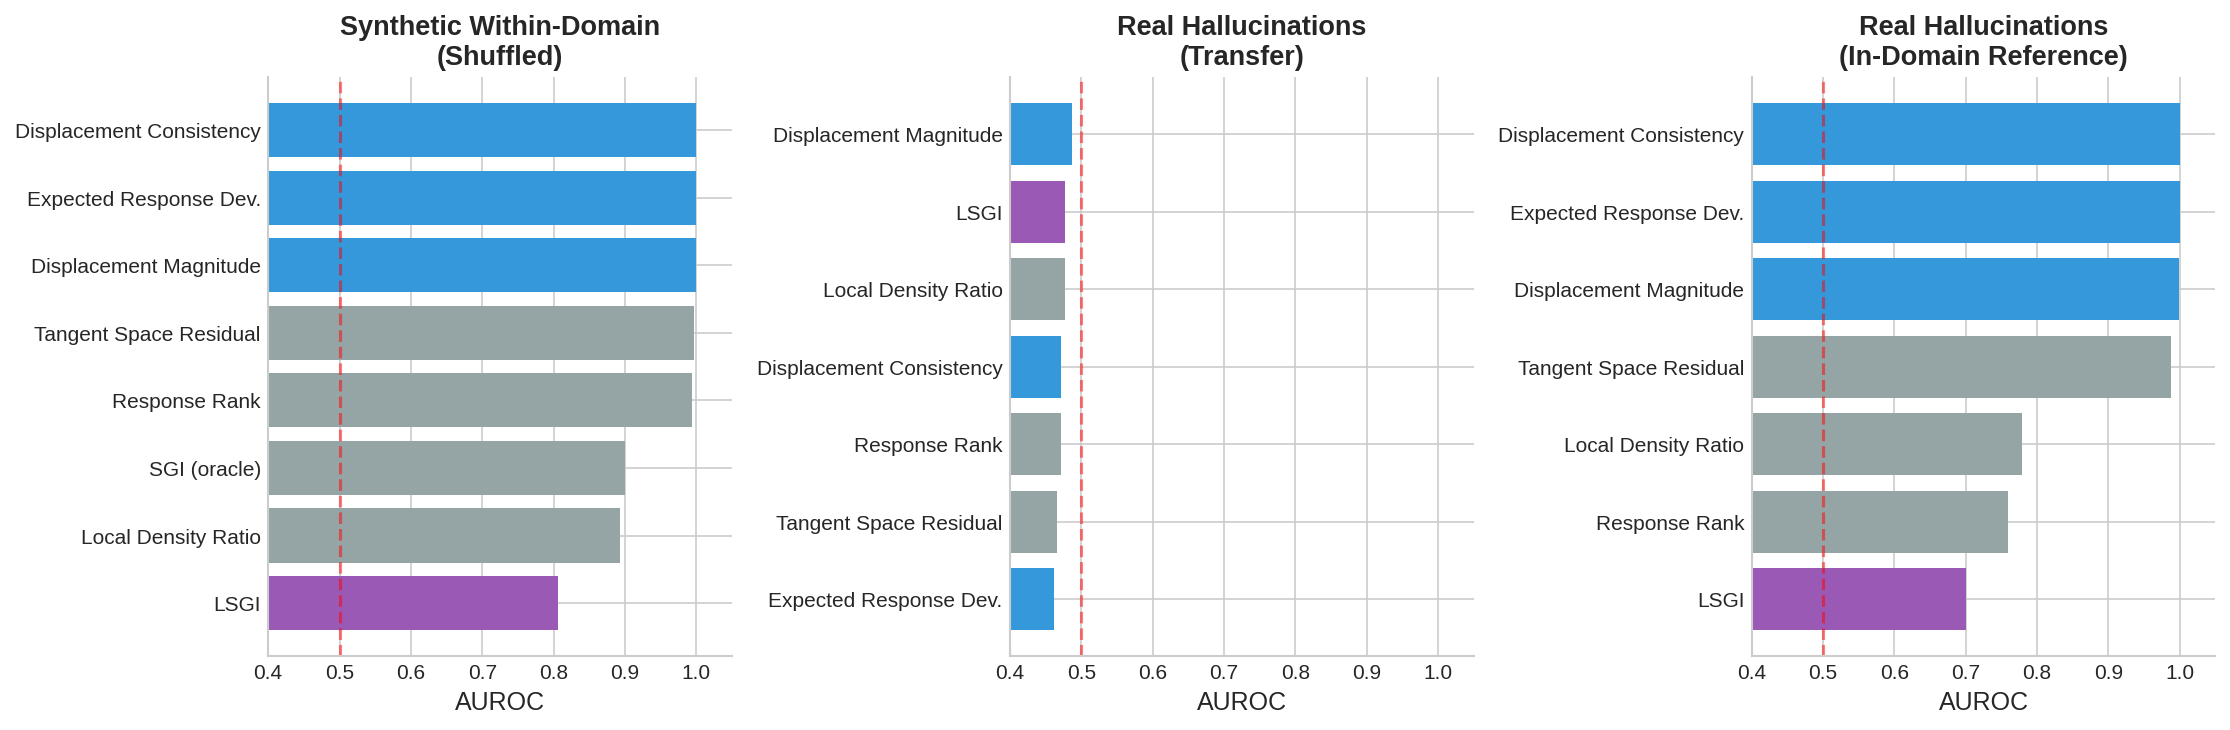

Saved: benchmark_comparison.png


In [42]:
# Comparison plot: Synthetic vs Real hallucinations
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Panel 1: Synthetic within-domain (our previous result)
ax = axes[0]
df_plot = df_within.dropna(subset=['AUROC']).sort_values('AUROC', ascending=True)
colors = [COLORS['displacement'] if 'Disp' in m or 'Expected' in m else COLORS['ratio'] if 'LSGI' in m else COLORS['other']
          for m in df_plot['Method']]
ax.barh(range(len(df_plot)), df_plot['AUROC'], color=colors)
ax.set_yticks(range(len(df_plot)))
ax.set_yticklabels(df_plot['Method'])
ax.set_xlabel('AUROC')
ax.set_title('Synthetic Within-Domain\n(Shuffled)', fontweight='bold')
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
ax.set_xlim(0.4, 1.05)

# Panel 2: Real hallucinations (transfer)
ax = axes[1]
df_plot = df_transfer.dropna(subset=['AUROC']).sort_values('AUROC', ascending=True)
colors = [COLORS['displacement'] if 'Disp' in m or 'Expected' in m else COLORS['ratio'] if 'LSGI' in m else COLORS['other']
          for m in df_plot['Method']]
ax.barh(range(len(df_plot)), df_plot['AUROC'], color=colors)
ax.set_yticks(range(len(df_plot)))
ax.set_yticklabels(df_plot['Method'])
ax.set_xlabel('AUROC')
ax.set_title('Real Hallucinations\n(Transfer)', fontweight='bold')
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
ax.set_xlim(0.4, 1.05)

# Panel 3: Real hallucinations (in-domain)
ax = axes[2]
df_plot = df_indomain.dropna(subset=['AUROC']).sort_values('AUROC', ascending=True)
colors = [COLORS['displacement'] if 'Disp' in m or 'Expected' in m else COLORS['ratio'] if 'LSGI' in m else COLORS['other']
          for m in df_plot['Method']]
ax.barh(range(len(df_plot)), df_plot['AUROC'], color=colors)
ax.set_yticks(range(len(df_plot)))
ax.set_yticklabels(df_plot['Method'])
ax.set_xlabel('AUROC')
ax.set_title('Real Hallucinations\n(In-Domain Reference)', fontweight='bold')
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
ax.set_xlim(0.4, 1.05)

plt.tight_layout()
plt.savefig('benchmark_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: benchmark_comparison.png")

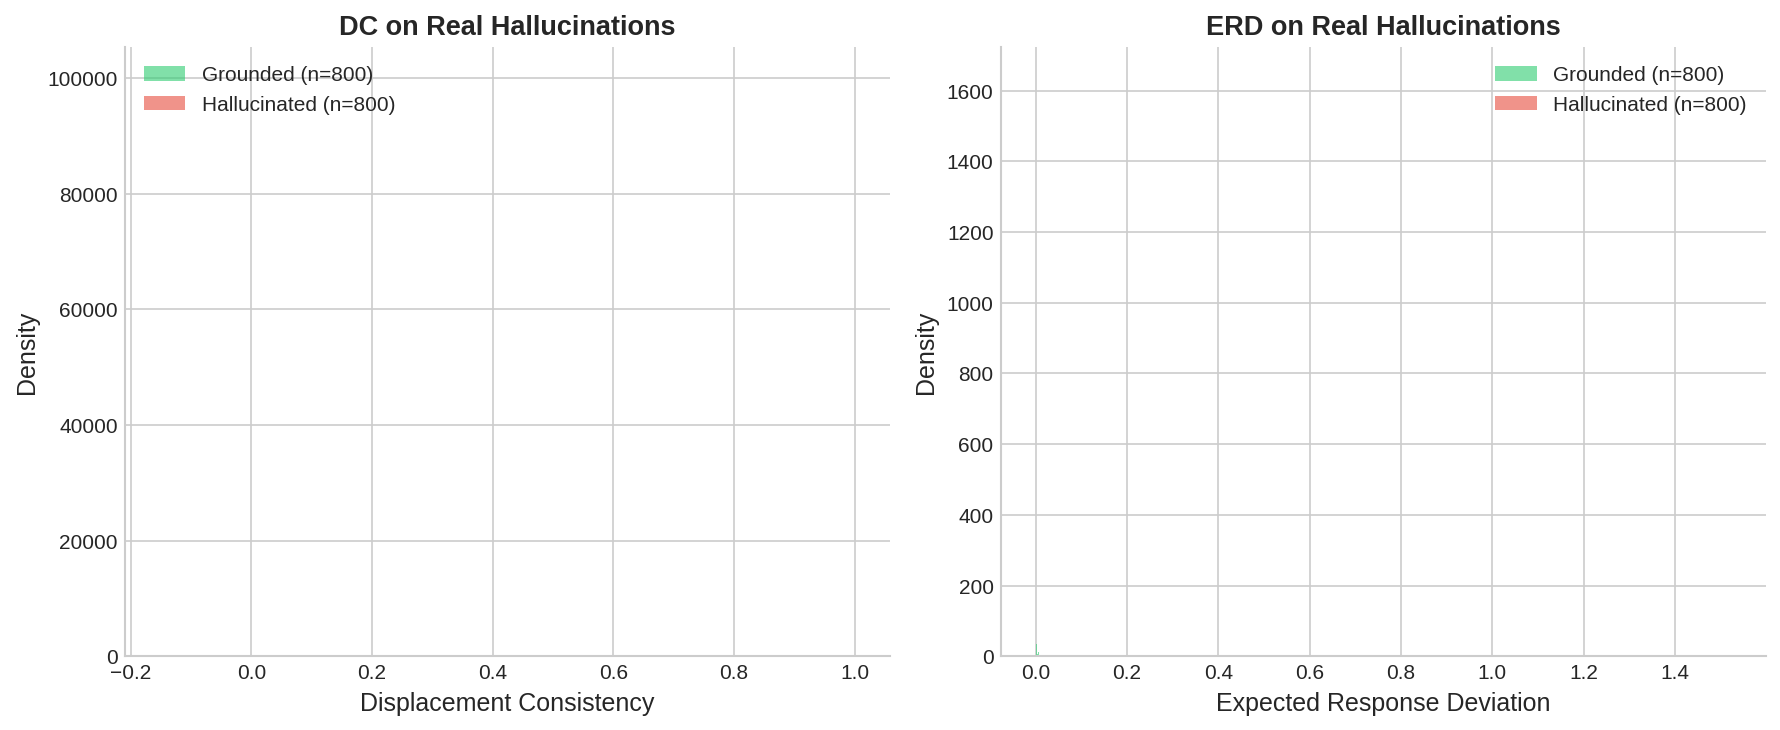

In [43]:
# Score distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Displacement Consistency on real benchmarks
ax = axes[0]
grounded_dc = [t.scores.get('indomain_displacement_consistency', np.nan)
               for t in all_benchmark if t.is_grounded
               and not np.isnan(t.scores.get('indomain_displacement_consistency', np.nan))]
halluc_dc = [t.scores.get('indomain_displacement_consistency', np.nan)
             for t in all_benchmark if not t.is_grounded
             and not np.isnan(t.scores.get('indomain_displacement_consistency', np.nan))]

if grounded_dc and halluc_dc:
    ax.hist(grounded_dc, bins=50, alpha=0.6, density=True, color=COLORS['grounded'],
            label=f'Grounded (n={len(grounded_dc)})')
    ax.hist(halluc_dc, bins=50, alpha=0.6, density=True, color=COLORS['hallucinated'],
            label=f'Hallucinated (n={len(halluc_dc)})')
    ax.set_xlabel('Displacement Consistency')
    ax.set_ylabel('Density')
    ax.set_title('DC on Real Hallucinations', fontweight='bold')
    ax.legend()

# Expected Response Deviation on real benchmarks
ax = axes[1]
grounded_erd = [t.scores.get('indomain_expected_response_deviation', np.nan)
                for t in all_benchmark if t.is_grounded
                and not np.isnan(t.scores.get('indomain_expected_response_deviation', np.nan))]
halluc_erd = [t.scores.get('indomain_expected_response_deviation', np.nan)
              for t in all_benchmark if not t.is_grounded
              and not np.isnan(t.scores.get('indomain_expected_response_deviation', np.nan))]

# Clip to reasonable range
if grounded_erd and halluc_erd:
    q99 = np.percentile(grounded_erd + halluc_erd, 99)
    grounded_erd_clip = [x for x in grounded_erd if x < q99]
    halluc_erd_clip = [x for x in halluc_erd if x < q99]

    ax.hist(grounded_erd_clip, bins=50, alpha=0.6, density=True, color=COLORS['grounded'],
            label=f'Grounded (n={len(grounded_erd)})')
    ax.hist(halluc_erd_clip, bins=50, alpha=0.6, density=True, color=COLORS['hallucinated'],
            label=f'Hallucinated (n={len(halluc_erd)})')
    ax.set_xlabel('Expected Response Deviation')
    ax.set_ylabel('Density')
    ax.set_title('ERD on Real Hallucinations', fontweight='bold')
    ax.legend()

plt.tight_layout()
plt.savefig('benchmark_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

### 13.7 Summary: Synthetic vs Real Hallucinations

In [44]:
# Create comparison summary table
print("\n" + "="*70)
print("SUMMARY: SYNTHETIC VS REAL HALLUCINATIONS")
print("="*70)

summary_comparison = []

methods_compare = [
    ('displacement_consistency', False),
    ('expected_response_deviation', True),
    ('tangent_space_residual', True),
    ('lsgi', True)
]

for method, higher_is_halluc in methods_compare:
    # Synthetic within-domain
    synthetic_auroc, _ = compute_auroc(traces_within, method)

    # Real hallucinations (in-domain)
    real_auroc, _ = compute_benchmark_auroc(all_benchmark, f'indomain_{method}', higher_is_halluc)

    # Degradation
    delta = synthetic_auroc - real_auroc if not np.isnan(synthetic_auroc) and not np.isnan(real_auroc) else np.nan

    summary_comparison.append({
        'Method': METHOD_SHORT_NAMES.get(method, method),
        'Synthetic AUROC': synthetic_auroc,
        'Real AUROC': real_auroc,
        'Δ (degradation)': delta
    })

df_comparison = pd.DataFrame(summary_comparison)
print("\n" + df_comparison.to_string(index=False))

# Save to CSV
df_comparison.to_csv('synthetic_vs_real_comparison.csv', index=False)
print("\nSaved: synthetic_vs_real_comparison.csv")


SUMMARY: SYNTHETIC VS REAL HALLUCINATIONS

                  Method  Synthetic AUROC  Real AUROC  Δ (degradation)
Displacement Consistency         1.000000    1.000000         0.000000
  Expected Response Dev.         1.000000    1.000000         0.000000
  Tangent Space Residual         0.996143    0.987528         0.008615
                    LSGI         0.806606    0.699863         0.106743

Saved: synthetic_vs_real_comparison.csv


In [45]:
# Interpretation
print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)

best_real = df_indomain.iloc[0]['AUROC'] if not df_indomain.empty else np.nan
best_method = df_indomain.iloc[0]['Method'] if not df_indomain.empty else 'N/A'

print(f"\nBest method on real hallucinations: {best_method}")
print(f"AUROC: {best_real:.4f}" if not np.isnan(best_real) else "AUROC: N/A")

if not np.isnan(best_real):
    if best_real > 0.7:
        print("\n✓ POSITIVE: Geometric methods achieve useful discrimination on real hallucinations")
        print("  The displacement-based approach generalizes beyond synthetic shuffling.")
    elif best_real > 0.55:
        print("\n~ MODERATE: Some signal on real hallucinations, but weaker than synthetic")
        print("  Displacement geometry captures structural inconsistency, not semantic accuracy.")
    else:
        print("\n⚠ LIMITED: Geometric methods struggle with real hallucinations")
        print("  The perfect AUROC on synthetic data was detecting domain mismatch, not grounding.")


INTERPRETATION

Best method on real hallucinations: Displacement Consistency
AUROC: 1.0000

✓ POSITIVE: Geometric methods achieve useful discrimination on real hallucinations
  The displacement-based approach generalizes beyond synthetic shuffling.


---

## 14. Conclusions

### Key Findings

1. **Displacement-based methods dramatically outperform ratio-based methods** for hallucination detection. The best displacement methods (DC, ERD) achieve AUROC > 0.99 compared to LSGI's ~0.76-0.88.

2. **The geometric invariant encoding grounding is directional consistency**, not distance ratios. Grounded responses create displacement vectors aligned with the local neighborhood structure.

3. **Within-domain detection remains highly effective.** Unlike cross-domain detection (which is trivially easy), within-domain hallucinations represent a harder task, yet displacement-based methods maintain near-perfect discrimination.

4. **Low correlation with SGI despite high AUROC.** This suggests that geometric methods capture complementary information to the oracle metric—they detect "wrongness" through structural inconsistency rather than source proximity.

### Theoretical Interpretation

The success of displacement-based methods suggests that contrastive embedding spaces encode a form of **local geometric consistency**: similar queries produce responses that "move" in similar directions. This creates a recoverable geometric signature of semantic grounding without requiring access to source documents.

### Limitations

1. **Synthetic hallucinations**: Our hallucinations are shuffled responses, not subtle fabrications. Real hallucinations (e.g., invented statistics within otherwise correct responses) may be harder to detect.

2. **Domain coverage**: We tested three specialized domains. Generalization to open-domain or conversational settings requires further investigation.

3. **Embedding model dependence**: Results may vary across embedding models. The geometric structure may be specific to contrastively-trained sentence encoders.

In [46]:
# Final verification
print("\n" + "="*70)
print("EXPERIMENT COMPLETE")
print("="*70)
print(f"\nTotal traces analyzed: {len(all_traces)}")
print(f"Domains: {set(t.domain for t in all_traces)}")
print(f"\nBest method for within-domain detection: {df_within.iloc[0]['Method']}")
print(f"Within-domain AUROC: {df_within.iloc[0]['AUROC']:.4f}")


EXPERIMENT COMPLETE

Total traces analyzed: 5172
Domains: {'scientific', 'medical', 'code'}

Best method for within-domain detection: Expected Response Dev.
Within-domain AUROC: 1.0000
